In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
# Load data
df = pd.read_csv("../data/processed/train_final.csv")
# Features / target
X = df.drop(columns=["PotentialFraud", "Provider"])
y = df["PotentialFraud"].astype(int)

# Encode object / categorical columns to numeric codes so tree models accept them
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
if len(cat_cols) > 0:
    print("Encoding categorical columns:", cat_cols)
    for c in cat_cols:
        X[c] = X[c].astype('category').cat.codes

# Train / validation / test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)


In [ ]:
def plot_curves(y_true, probs, label):
    # create two subplots and draw diagnostics into specified axes
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    RocCurveDisplay.from_predictions(y_true, probs, ax=axes[0])
    axes[0].set_title(f"ROC Curve - {label}")
    PrecisionRecallDisplay.from_predictions(y_true, probs, ax=axes[1])
    axes[1].set_title(f"PR Curve - {label}")
    plt.tight_layout()
    plt.show()


In [ ]:
def evaluate_model(name, y_true, y_pred, y_prob, threshold=0.5):
    """Evaluate binary classification predictions and probabilities, print metrics, and return a summary dict."""
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    avg_prec = average_precision_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)

    result = {
        "model": name,
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "roc_auc": float(roc_auc),
        "avg_precision": float(avg_prec),
        "confusion_matrix": cm.tolist()
    }

    print(f"{name} — Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}, AP: {avg_prec:.4f}")
    print("Confusion matrix:")
    print(cm)

    return result


In [ ]:
# Handle imbalance weight
scale = (y_train == 0).sum() / (y_train == 1).sum()

xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

param_grid_xgb = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 4, 5, 8 , 12],
    "learning_rate": [0.05, 0.03, 0.01],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.7, 0.9]
}

grid_xgb = GridSearchCV(
    xgb_base,
    param_grid_xgb,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)

print("Best XGB params:", grid_xgb.best_params_)
print("Best XGB AP Score:", grid_xgb.best_score_)

# Calibrate final model
xgb_best = grid_xgb.best_estimator_

xgb_cal = CalibratedClassifierCV(xgb_best, method="isotonic", cv=3)
xgb_cal.fit(X_train, y_train)

xgb_probs = xgb_cal.predict_proba(X_val)[:, 1]
xgb_preds = (xgb_probs > 0.5).astype(int)

xgb_result = evaluate_model("XGBoost (Calibrated)", y_val, xgb_preds, xgb_probs)
plot_curves(y_val, xgb_probs, "XGBoost (Calibrated)")

xgb_result



Training Samples: Non-Fraud (0) = 3923, Fraud (1) = 405
Calculated scale_pos_weight: 9.69

Starting Grid Search with enhanced parameters and scale_pos_weight...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [23:02:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best XGB params (Focus on Recall): {'colsample_bytree': 0.7, 'learning_rate': 0.005, 'max_depth': 2, 'n_estimators': 600, 'scale_pos_weight': np.float64(9.686419753086419), 'subsample': 0.8}
Best XGB AP Score (Cross-Validation): nan
Best Model AP Score on Validation Set: 0.7329


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best LR params: {'C': 10.0, 'solver': 'lbfgs'}
Best LR AP Score: 0.7319165360779125
LogReg (Calibrated) — Precision: 0.7838, Recall: 0.5686, F1: 0.6591, ROC AUC: 0.9752, AP: 0.7838
Confusion matrix:
[[482   8]
 [ 22  29]]
Best LR params: {'C': 10.0, 'solver': 'lbfgs'}
Best LR AP Score: 0.7319165360779125
LogReg (Calibrated) — Precision: 0.7838, Recall: 0.5686, F1: 0.6591, ROC AUC: 0.9752, AP: 0.7838
Confusion matrix:
[[482   8]
 [ 22  29]]


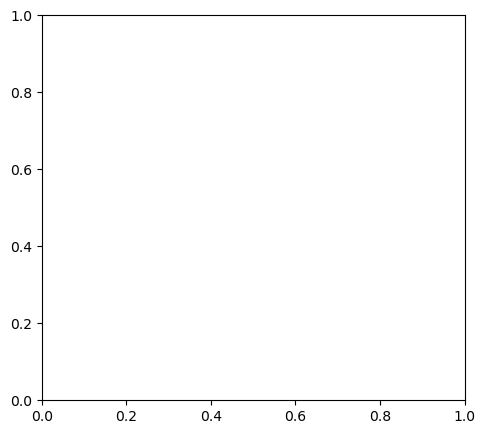

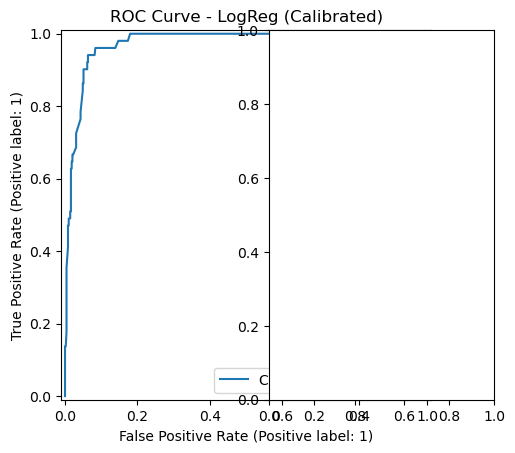

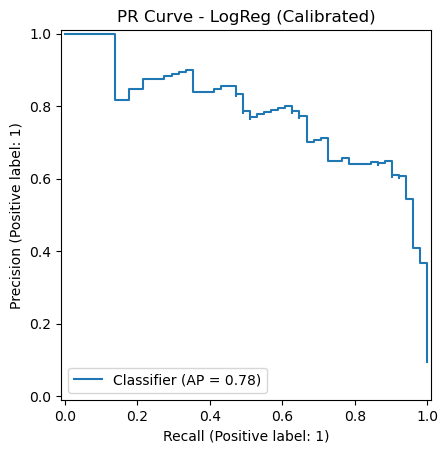

{'model': 'LogReg (Calibrated)',
 'precision': 0.7837837837837838,
 'recall': 0.5686274509803921,
 'f1': 0.6590909090909091,
 'roc_auc': 0.9751700680272108,
 'avg_precision': 0.7837761829215828,
 'confusion_matrix': [[482, 8], [22, 29]]}

In [20]:
from sklearn.preprocessing import StandardScaler

# Scale LR features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

lr_base = LogisticRegression(
    penalty="l2",
    class_weight="balanced",
    random_state=42,
    max_iter=5000
)

param_grid_lr = {
    "C": [0.01, 0.1, 0.3, 1.0, 3.0, 10.0],
    "solver": ["lbfgs", "liblinear"]
}

grid_lr = GridSearchCV(
    lr_base,
    param_grid_lr,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train_scaled, y_train)

print("Best LR params:", grid_lr.best_params_)
print("Best LR AP Score:", grid_lr.best_score_)

# Calibrate LR
lr_best = grid_lr.best_estimator_

lr_cal = CalibratedClassifierCV(lr_best, method="isotonic", cv=3)
lr_cal.fit(X_train_scaled, y_train)

lr_probs = lr_cal.predict_proba(X_val_scaled)[:, 1]
lr_preds = (lr_probs > 0.5).astype(int)

lr_result = evaluate_model("LogReg (Calibrated)", y_val, lr_preds, lr_probs)
plot_curves(y_val, lr_probs, "LogReg (Calibrated)")

lr_result


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best RF params: {'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best RF AP Score: 0.7307339527082131
Best RF params: {'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best RF AP Score: 0.7307339527082131
Random Forest (Calibrated) — Precision: 0.8158, Recall: 0.6078, F1: 0.6966, ROC AUC: 0.9708, AP: 0.7410
Confusion matrix:
[[483   7]
 [ 20  31]]
Random Forest (Calibrated) — Precision: 0.8158, Recall: 0.6078, F1: 0.6966, ROC AUC: 0.9708, AP: 0.7410
Confusion matrix:
[[483   7]
 [ 20  31]]


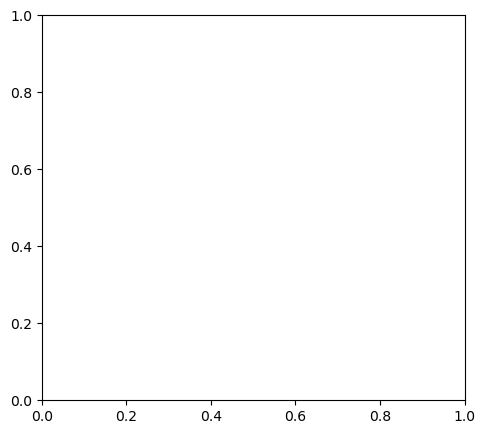

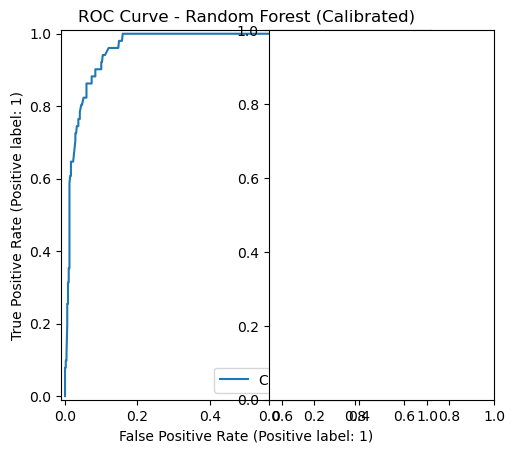

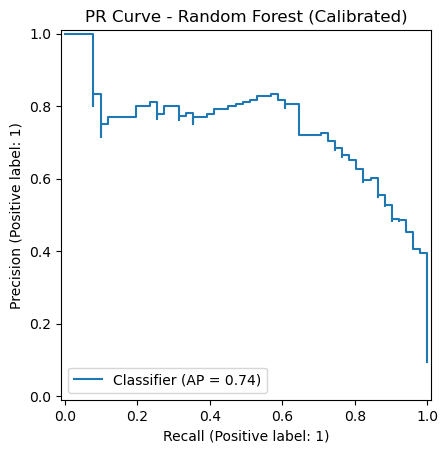

{'model': 'Random Forest (Calibrated)',
 'precision': 0.8157894736842105,
 'recall': 0.6078431372549019,
 'f1': 0.6966292134831461,
 'roc_auc': 0.9708083233293318,
 'avg_precision': 0.7410479124967784,
 'confusion_matrix': [[483, 7], [20, 31]]}

In [21]:
rf_base = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

param_grid_rf = {
    "n_estimators": [200, 400, 600],
    "max_depth": [8, 12, 16, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_rf = GridSearchCV(
    rf_base,
    param_grid_rf,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
print("Best RF AP Score:", grid_rf.best_score_)

# Calibrate
rf_best = grid_rf.best_estimator_

rf_cal = CalibratedClassifierCV(rf_best, method="isotonic", cv=3)
rf_cal.fit(X_train, y_train)

rf_probs = rf_cal.predict_proba(X_val)[:, 1]
rf_preds = (rf_probs > 0.5).astype(int)

rf_result = evaluate_model("Random Forest (Calibrated)", y_val, rf_preds, rf_probs)
plot_curves(y_val, rf_probs, "Random Forest (Calibrated)")

rf_result


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Load data
df = pd.read_csv("../data/processed/train_final.csv")
# Features / target
X = df.drop(columns=["PotentialFraud", "Provider"])
y = df["PotentialFraud"].astype(int)

# Encode object / categorical columns to numeric codes so tree models accept them
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
if len(cat_cols) > 0:
    print("Encoding categorical columns:", cat_cols)
    for c in cat_cols:
        X[c] = X[c].astype('category').cat.codes

# Train / validation / test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)


In [ ]:
def plot_curves(y_true, probs, label):
    # create two subplots and draw diagnostics into specified axes
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    RocCurveDisplay.from_predictions(y_true, probs, ax=axes[0])
    axes[0].set_title(f"ROC Curve - {label}")
    PrecisionRecallDisplay.from_predictions(y_true, probs, ax=axes[1])
    axes[1].set_title(f"PR Curve - {label}")
    plt.tight_layout()
    plt.show()


In [ ]:
def evaluate_model(name, y_true, y_pred, y_prob, threshold=0.5):
    """Evaluate binary classification predictions and probabilities, print metrics, and return a summary dict."""
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    avg_prec = average_precision_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)

    result = {
        "model": name,
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "roc_auc": float(roc_auc),
        "avg_precision": float(avg_prec),
        "confusion_matrix": cm.tolist()
    }

    print(f"{name} — Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}, AP: {avg_prec:.4f}")
    print("Confusion matrix:")
    print(cm)

    return result


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best XGB params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 600, 'subsample': 1.0}
Best XGB AP Score: 0.7574192546203127
Best XGB params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 600, 'subsample': 1.0}
Best XGB AP Score: 0.7574192546203127
XGBoost (Calibrated) — Precision: 0.8205, Recall: 0.6275, F1: 0.7111, ROC AUC: 0.9759, AP: 0.7648
Confusion matrix:
[[483   7]
 [ 19  32]]
XGBoost (Calibrated) — Precision: 0.8205, Recall: 0.6275, F1: 0.7111, ROC AUC: 0.9759, AP: 0.7648
Confusion matrix:
[[483   7]
 [ 19  32]]


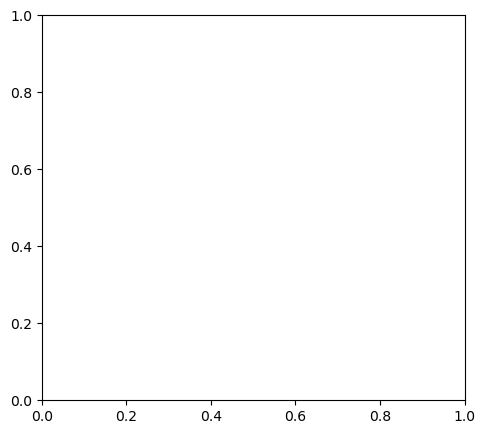

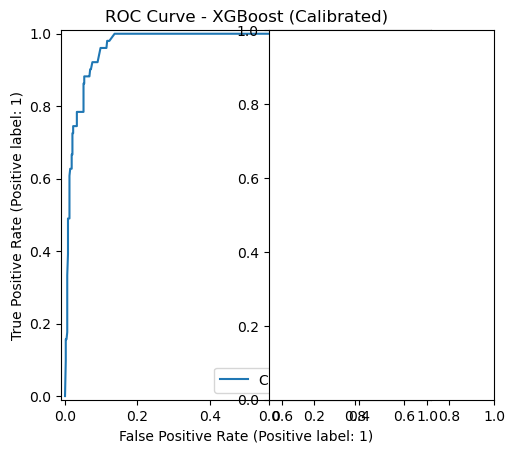

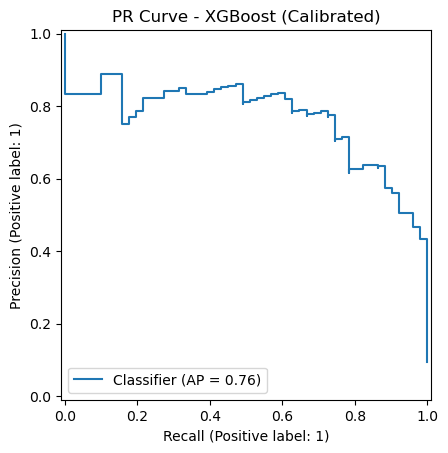

{'model': 'XGBoost (Calibrated)',
 'precision': 0.8205128205128205,
 'recall': 0.6274509803921569,
 'f1': 0.7111111111111111,
 'roc_auc': 0.9758503401360543,
 'avg_precision': 0.7648020255036647,
 'confusion_matrix': [[483, 7], [19, 32]]}

In [25]:
# Handle imbalance weight
scale = (y_train == 0).sum() / (y_train == 1).sum()

xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

param_grid_xgb = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.05, 0.03, 0.01],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.7, 0.9]
}

grid_xgb = GridSearchCV(
    xgb_base,
    param_grid_xgb,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)

print("Best XGB params:", grid_xgb.best_params_)
print("Best XGB AP Score:", grid_xgb.best_score_)

# Calibrate final model
xgb_best = grid_xgb.best_estimator_

xgb_cal = CalibratedClassifierCV(xgb_best, method="isotonic", cv=3)
xgb_cal.fit(X_train, y_train)

xgb_probs = xgb_cal.predict_proba(X_val)[:, 1]
xgb_preds = (xgb_probs > 0.5).astype(int)

xgb_result = evaluate_model("XGBoost (Calibrated)", y_val, xgb_preds, xgb_probs)
plot_curves(y_val, xgb_probs, "XGBoost (Calibrated)")

xgb_result


Logistic Regression — Precision: 0.5052, Recall: 0.9608, F1: 0.6622, ROC AUC: 0.9753, AP: 0.7925
Confusion matrix:
[[442  48]
 [  2  49]]
{'model': 'Logistic Regression', 'precision': 0.5051546391752577, 'recall': 0.9607843137254902, 'f1': 0.6621621621621622, 'roc_auc': 0.9753101240496198, 'avg_precision': 0.7925152947382099, 'confusion_matrix': [[442, 48], [2, 49]]}


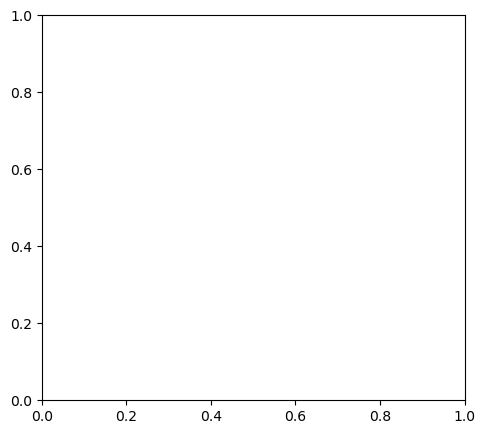

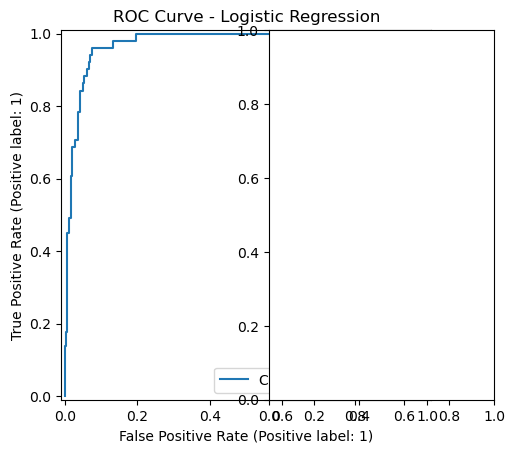

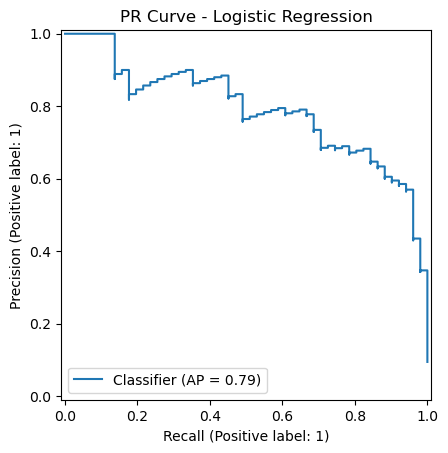

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale LR features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

lr_base = LogisticRegression(
    penalty="l2",
    class_weight="balanced",
    random_state=42,
    max_iter=5000
)

param_grid_lr = {
    "C": [0.01, 0.1, 0.3, 1.0, 3.0, 10.0],
    "solver": ["lbfgs", "liblinear"]
}

grid_lr = GridSearchCV(
    lr_base,
    param_grid_lr,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train_scaled, y_train)

print("Best LR params:", grid_lr.best_params_)
print("Best LR AP Score:", grid_lr.best_score_)

# Calibrate LR
lr_best = grid_lr.best_estimator_

lr_cal = CalibratedClassifierCV(lr_best, method="isotonic", cv=3)
lr_cal.fit(X_train_scaled, y_train)

lr_probs = lr_cal.predict_proba(X_val_scaled)[:, 1]
lr_preds = (lr_probs > 0.5).astype(int)

lr_result = evaluate_model("LogReg (Calibrated)", y_val, lr_preds, lr_probs)
plot_curves(y_val, lr_probs, "LogReg (Calibrated)")

lr_result


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best RF params: {'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best RF AP Score: 0.7307339527082131
Best RF params: {'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best RF AP Score: 0.7307339527082131
Random Forest (Calibrated) — Precision: 0.8158, Recall: 0.6078, F1: 0.6966, ROC AUC: 0.9708, AP: 0.7410
Confusion matrix:
[[483   7]
 [ 20  31]]
Random Forest (Calibrated) — Precision: 0.8158, Recall: 0.6078, F1: 0.6966, ROC AUC: 0.9708, AP: 0.7410
Confusion matrix:
[[483   7]
 [ 20  31]]


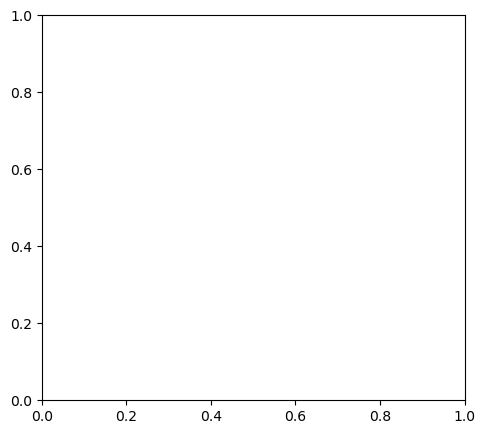

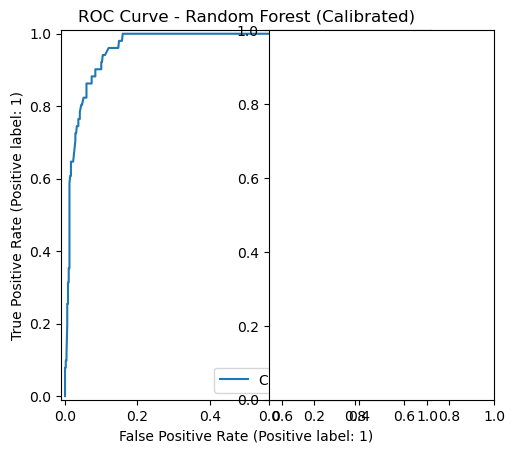

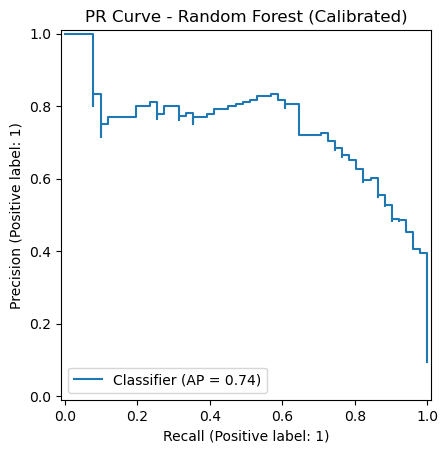

{'model': 'Random Forest (Calibrated)',
 'precision': 0.8157894736842105,
 'recall': 0.6078431372549019,
 'f1': 0.6966292134831461,
 'roc_auc': 0.9708083233293318,
 'avg_precision': 0.7410479124967784,
 'confusion_matrix': [[483, 7], [20, 31]]}

In [23]:
rf_base = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

param_grid_rf = {
    "n_estimators": [200, 400, 600],
    "max_depth": [8, 12, 16, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_rf = GridSearchCV(
    rf_base,
    param_grid_rf,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
print("Best RF AP Score:", grid_rf.best_score_)

# Calibrate
rf_best = grid_rf.best_estimator_

rf_cal = CalibratedClassifierCV(rf_best, method="isotonic", cv=3)
rf_cal.fit(X_train, y_train)

rf_probs = rf_cal.predict_proba(X_val)[:, 1]
rf_preds = (rf_probs > 0.5).astype(int)

rf_result = evaluate_model("Random Forest (Calibrated)", y_val, rf_preds, rf_probs)
plot_curves(y_val, rf_probs, "Random Forest (Calibrated)")

rf_result


In [15]:
df.columns.tolist()


['Provider',
 'IP_NumClaims',
 'IP_NumBeneficiaries',
 'IP_AvgReimbursement',
 'IP_TotalReimbursement',
 'IP_MaxReimbursement',
 'IP_StdReimbursement',
 'IP_MedianReimbursement',
 'IP_AvgDeductible',
 'IP_TotalDeductible',
 'IP_AvgClaimDuration',
 'IP_TotalClaimDuration',
 'IP_MaxClaimDuration',
 'IP_StdClaimDuration',
 'IP_AvgAdmissionDuration',
 'IP_TotalAdmissionDuration',
 'IP_MaxAdmissionDuration',
 'IP_StdAdmissionDuration',
 'IP_NumAttendingPhysicians',
 'IP_NumOperatingPhysicians',
 'IP_NumOtherPhysicians',
 'IP_ClaimsPerBeneficiary',
 'IP_ReimbursementPerDay',
 'IP_ReimbursementPerBeneficiary',
 'IP_TotalPhysicians',
 'IP_TotalUniqueDiagnoses',
 'IP_TotalUniqueProcedures',
 'OP_NumClaims',
 'OP_NumBeneficiaries',
 'OP_AvgReimbursement',
 'OP_TotalReimbursement',
 'OP_MaxReimbursement',
 'OP_StdReimbursement',
 'OP_MedianReimbursement',
 'OP_AvgDeductible',
 'OP_TotalDeductible',
 'OP_AvgClaimDuration',
 'OP_TotalClaimDuration',
 'OP_MaxClaimDuration',
 'OP_StdClaimDuration',
 

In [16]:
df.nunique().sort_values()

IP_AvgDeductible                     2
PotentialFraud                       2
OP_TotalUniqueProcedures             7
IP_NumOtherPhysicians               21
OP_MaxClaimDuration                 23
IP_MaxAdmissionDuration             36
IP_MaxClaimDuration                 37
IP_NumOperatingPhysicians           42
IP_NumAttendingPhysicians           55
IP_MedianReimbursement              72
OP_NumOperatingPhysicians           79
IP_TotalPhysicians                  91
IP_TotalUniqueProcedures            98
OP_MedianReimbursement             103
IP_MaxReimbursement                106
OP_NumOtherPhysicians              111
IP_NumBeneficiaries                139
IP_TotalDeductible                 146
IP_NumClaims                       150
OP_NumAttendingPhysicians          160
OP_MaxReimbursement                224
IP_ClaimsPerBeneficiary            266
OP_TotalDeductible                 296
IP_TotalAdmissionDuration          420
IP_TotalClaimDuration              421
OP_NumBeneficiaries      